# Director Skill Sets Table 7 - Departures only

In [1]:
import pandas_datareader.data as web #to collect data
import datetime as dt #to specify start and end dates

# import yfinance as yf

import eventstudy as es
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.spatial.distance import cdist


from sklearn.neighbors import NearestNeighbors

import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

from patsy import dmatrices
from tqdm.notebook import tqdm
tqdm.pandas()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import_folder_path = rf"C:\Users\SHIVAM\Desktop\Finance\Kavitha Ranganathan TAPMI\Rookie Directors Project\Data Analysis\Data Analysis\[IN USE] Rookie Directors\CAPM CAR precode\car_output4"
output_folder_path = "analysis_outputs"
pca_input_folder_path = rf"C:\Users\SHIVAM\Desktop\Finance\Kavitha Ranganathan TAPMI\Rookie Directors Project\Data Analysis\Data Analysis\[IN USE] Rookie Directors\Director Skills PCA\director_skills_pca"
supporting_folder_path = "supporting_datafiles"

In [3]:
dirFirm0 = pd.read_pickle(rf"{import_folder_path}\Director Level_MF_CAR.pkl")
pca = pd.read_pickle(rf"{pca_input_folder_path}\Main_Director_COMPLETE_PCA.pkl")

pca_col = [
    "Person Code", "AsOnDate", "Symbol",
    "SkillsetIndex", "SkillsetGeneralistDummy",
    "PC1_FactorScore", "PC1_FactorScore_Standardised"
]

pca2 = pca[pca_col].copy()
dirFirm = dirFirm0.merge(pca2, on = ["Person Code", "AsOnDate", "Symbol"], how = "left")

In [4]:
# dirFirm data wrangling if any:
dirFirm["Appointment Year"] = [x.year for x in dirFirm["Appointment Date"]]

dirFirm = dirFirm.drop_duplicates(subset = ["Person Code", "Company", "Appointment Date"]).reset_index(drop = True)

dirFirm["ln_dirage"] = np.log(dirFirm["Age"] + 1).astype("float")
dirFirm["ln_directorships"] = np.log(dirFirm["CompCountOtherPastTotalAB"] + 1).astype("float")

In [5]:
dirFirm

,Symbol,Company,AsOnDate,AsOnYear,ISIN,Person Code,Director Salutation,Director First Name,Director Middle Name,Director Surname,Date of Birth,Gender,Nationality,Member of Civil Services,Promoter Director (Yes/No),Position on Board,Independent (Yes/No),Education1,Education2,Education3,Education4,Education5,Education6,Education7,Education8,Education9,Education10,Skills/Competencies,Occupation,Cessation Reason,Other Directorship 1,Other Directorship 2,Other Directorship 3,Other Directorship 4,Other Directorship 5,Other Directorship 6,Other Directorship 7,Other Directorship 8,Other Directorship 9,Other Directorship 10,Other Directorship 11,Other Directorship 12,Other Directorship 13,Other Directorship 14,Other Directorship 15,Brief Profile,Tenure Valid till,Indep,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,AllPastDirect,CurrDirectA,CurrDirectAB,PastSiezedDirectA,PastSiezedDirectAB,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,Rookie,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,NSE symbol,NIC code,Entity type,Ownership group,Prowess company code,CompanyName,Skills,EducationAll,IsMBA,IsPhD,AllPastDirectNIC,CurrDirectANIC,CurrDirectABNIC,AllNIC,AllNIC_Industry,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,SkillsInPositiononBoard,SkillsInOccupation,AllSkills,HasTechSkill,HasFinanceSkill,FirmsPast,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,Committee Name,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,co

# PSM

## Verifying and removing those rows with no control data points

In [6]:
# Sample constraints ---> govtdummy==0 & findummy==0 & asonyear>2012
dirFirm.columns.to_list()

['Symbol',
 'Company',
 'AsOnDate',
 'AsOnYear',
 'ISIN',
 'Person Code',
 'Director Salutation',
 'Director First Name',
 'Director Middle Name',
 'Director Surname',
 'Date of Birth',
 'Gender',
 'Nationality',
 'Member of Civil Services',
 'Promoter Director (Yes/No)',
 'Position on Board',
 'Independent (Yes/No)',
 'Education1',
 'Education2',
 'Education3',
 'Education4',
 'Education5',
 'Education6',
 'Education7',
 'Education8',
 'Education9',
 'Education10',
 'Skills/Competencies',
 'Occupation',
 'Cessation Reason',
 'Other Directorship 1',
 'Other Directorship 2',
 'Other Directorship 3',
 'Other Directorship 4',
 'Other Directorship 5',
 'Other Directorship 6',
 'Other Directorship 7',
 'Other Directorship 8',
 'Other Directorship 9',
 'Other Directorship 10',
 'Other Directorship 11',
 'Other Directorship 12',
 'Other Directorship 13',
 'Other Directorship 14',
 'Other Directorship 15',
 'Brief Profile',
 'Tenure Valid till',
 'Indep',
 'Appointment Date',
 'Cessation Date'

In [7]:
dirFirm["IsDualityChairmanMD"] = dirFirm["IsDualityChairmanMD"].astype(int)


# dirFirm["NIC_2digit"] = dirFirm["NIC code"].dropna().apply(lambda x: x[0:2])
# dirFirm["NIC_2digit"] = dirFirm["NIC_2digit"]

psmSample = dirFirm.loc[ (dirFirm["Appointment Date"] >= "2013-03-31")].copy()
# \
# & (dirFirm["govtdummy"] == 0) & (dirFirm["findummy"] == 0) ].copy()
#.dropna(subset = controlVars).dropna(subset = dependentVar).copy()

psmSample["DummySum"] = psmSample["IsRookie"] + psmSample["IsNonRookie"]
psmSample["DummySumIndep"] = psmSample["IsRookieIndep"] + psmSample["IsNonRookieIndep"]

psmSampleAll = psmSample.loc[ psmSample["DummySum"] == 1 ].reset_index(drop = True)

psmSampleIndep = psmSample.loc[ psmSample["DummySumIndep"] == 1 ].reset_index(drop = True)

In [8]:
# dirFirm2 = dirFirm.copy()
# psmSampleIndep2 = psmSampleIndep.copy()

# listCol = [
#     "FirstYearPCodeList", "TwoYearPCodeList", "ThreeYearPCodeList", "PCodeList",
#     "FirstYearIndepPCodeList", "TwoYearIndepPCodeList", "ThreeYearIndepPCodeList", "IndepPCodeList",
#     "OtherFirstYearIndepPCode", "OtherTwoYearIndepPCode", "OtherThreeYearIndepPCode", "TotalIndepPCode",
#     "OtherFirstYearPCode", "OtherTwoYearPCode", "OtherThreeYearPCode", "TotalPCode",
#     "OtherFirstYearPCodeIndepExcl","OtherTwoYearPCodeIndepExcl", "OtherThreeYearPCodeIndepExcl", "TotalPCodeIndepExcl",
#     "OtherFirstYearPCodeExcl", "OtherTwoYearPCodeExcl", "OtherThreeYearPCodeExcl", "TotalPCodeExcl"
# ]

# dirFirm2 = dirFirm2.drop(listCol, axis = 1)
# psmSampleIndep2 = psmSampleIndep2.drop(listCol, axis = 1)


# dirFirm2.to_csv("Main_Firm_PSM Ready_no filter v040425.csv")
# psmSampleIndep2.to_csv("Main_Firm_PSM Ready_filter-Indep_gov_fin v040425.csv")


# # # psmSampleAll --> 2101 rows 
# # psmSampleIndep --> 1561 rows 

## PSM --> RookieAppoints as Treatment, NonRookieAppoints as Control

In [9]:
def LogitReg(sample, endog_var, exog_var):
    
    # Logit Regression
    endog = sample[[endog_var]]
    exog = sample[exog_var]
    exog = sm.add_constant(exog)
    
    log_reg = sm.Logit(endog, exog).fit()

    propensityScores = log_reg.predict(exog)
    
    return propensityScores

In [10]:
def MeanDiffTtest(sample, endog_var, exog_var, car, depVar, dirFirm):
    
    sample[car] = winsorize(sample[car], limits = [0.01, 0.01])
    
    if depVar != None:
        dirFirm = dirFirm.rename( {depVar:f"{depVar}_2"}, axis = 1)
    
        colsAdd = []
        for i in range(-1, 4):
            if i != 0:
                colsAdd.append(f"AsOnYear_T+{i}")
                colsAdd.append(f"{depVar}T+{i}")
                if i>0 :
                    colsAdd.append(depVar+f"(T+{i}) - (T-1)")
    
        newFrame= pd.DataFrame(columns = colsAdd, data = 0, index = sample.index, dtype = "int")
        sample = pd.concat([sample, newFrame], axis = 1)
        sample = sample.copy()
        
        for i in range(-1, 4):
            if i != 0:
                sample.loc[:, f"AsOnYear_T+{i}"] = sample["AsOnYear"] + i
    
        for i in range(-1, 4):
            if i != 0:
                sample.loc[:, f"{depVar}T+{i}"] = sample.merge(dirFirm[["Symbol", "AsOnYear", f"{depVar}_2"]].copy(), left_on = ["Symbol", f"AsOnYear_T+{i}"],
                                                              right_on = ["Symbol", "AsOnYear"], how = "left")[f"{depVar}_2"]
        
        for i in range(1, 4):
            if i != 0:
                sample.loc[:, depVar+f"(T+{i}) - (T-1)"] = sample[f"{depVar}T+{i}"] - sample[f"{depVar}T+-1"]
    
            
        sample = sample.copy()
    
    group1 = sample.loc[ sample[endog_var] == 1].copy()
    group2 = sample.loc[ sample[endog_var] == 0].copy()
    
    t_stat, p_value = stats.ttest_ind(group1[car], group2[car], equal_var=False)  # Welch’s t-test (default)

    print("\n")
    print(car, ":")
    print("\n")
    print("T Statistic:", t_stat, " P Value:",p_value)
    print("Treated Mean:", group1[car].mean(), " Control Mean:", group2[car].mean(), " Diff:", group1[car].mean() - group2[car].mean())
    print("Treated Median:", group1[car].median(), " Control Median:", group2[car].median(), " Diff:", group1[car].median() - group2[car].median())
    print("Treated N:", len(group1[car]), "; Control N:", len(group2[car]))
    print("[treated unique = ", len(group1.loc[ :, ["Person Code", "Symbol", "AsOnDate"]].drop_duplicates()), "]",\
          "[control unique = ", len(group2.loc[ :, ["Person Code", "Symbol", "AsOnDate"]].drop_duplicates()), "]"
         )
    print("\n")

    # -----------------------------------------------------------------------------------------------------------------
    
    if exog_var != None:
        print("━"*120)
        print(f'{"Matching Variable":<40} {"Treatment Firms":<20} {"Control Firms":<20} {"Test of Diff (p value)":<20}')
        print(f'{" ":<40} {"N = " + str(len(group1[car])):<20} {"N = " + str(len(group2[car])):<20}')
        print("-"*120)

        for var in exog_var:
            treatMean = group1[var].mean()
            controlMean = group2[var].mean()
            p_value = stats.ttest_ind(group1[var], group2[var], equal_var=False)[1]
            print(f'{var:<40} {treatMean:<20.4f} {controlMean:<20.4f} {p_value:<20.4f}')
    
        print("━"*120, "\n")
    
    # -----------------------------------------------------------------------------------------------------------------


    if depVar != None:
        print(depVar, " across years:\n")
        for i in range(1,4):
            sample = sample.dropna(subset = [depVar+f'(T+{i}) - (T-1)'])
    
        group1 = sample.loc[ sample[endog_var] == 1].copy()
        group2 = sample.loc[ sample[endog_var] == 0].copy()

        print("━"*150, "\n")
        print(f'{depVar:<40}{" ":<20}{"Treatment Firms":<20}{"Control Firms":<20}{"Difference":<20}{"Test of Diff":<20}{"Test of Diff"}')
        print(f'{" ":<120}{"(t stat)":<20}{"(p value)":<20}')
    
        print("─"*150, "\n")
    
        for i in range(1,4):
            t_stat2, p_value2 = stats.ttest_ind(group1[depVar+f'(T+{i}) - (T-1)'], group2[depVar+f'(T+{i}) - (T-1)'], equal_var=False)  # Welch’s t-test (default)
            
            treatedMean = group1[depVar+f'(T+{i}) - (T-1)'].mean()
            controlMean = group2[depVar+f'(T+{i}) - (T-1)'].mean()
            diffMean = treatedMean - controlMean
    
            treatedMedian = group1[depVar+f'(T+{i}) - (T-1)'].median()
            controlMedian = group2[depVar+f'(T+{i}) - (T-1)'].median()
            diffMedian = treatedMedian - controlMedian
    
            print(f'{"Year_T+" + str(i) +" - Year_T-1":<40}{"<MEAN>":<20}{treatedMean:<20.4f}{controlMean:<20.4f}{diffMean:<20.4f}{t_stat2:<20.4f}{p_value2:<20.10f}')
    
            label1 = "Treated N: " + str(len(group1[depVar+f'(T+{i}) - (T-1)']))
            label2 = "Control N: " + str(len(group2[depVar+f'(T+{i}) - (T-1)']))
            
            print(f'{label1 + " "*5 + label2:<40}{"<MEDIAN>":<20}{treatedMedian:<20.4f}{controlMedian:<20.4f}{diffMedian:<20.4f}')
            
            print("-"*150, "\n")
            
        print("━"*150, "\n")

    return

In [11]:
def OneSampleTtest(sample, endog_var, exog_var, car, depVar, dirFirm):

    # if depVar != None:
    #     dirFirm = dirFirm.rename( {depVar:f"{depVar}_2"}, axis = 1)
    
    #     colsAdd = []
    #     for i in range(-1, 4):
    #         if i != 0:
    #             colsAdd.append(f"AsOnYear_T+{i}")
    #             colsAdd.append(f"{depVar}T+{i}")
    #             if i>0 :
    #                 colsAdd.append(depVar+f"(T+{i}) - (T-1)")
    
    #     newFrame= pd.DataFrame(columns = colsAdd, data = 0, index = sample.index, dtype = "int")
    #     sample = pd.concat([sample, newFrame], axis = 1)
    #     sample = sample.copy()
        
    #     for i in range(-1, 4):
    #         if i != 0:
    #             sample.loc[:, f"AsOnYear_T+{i}"] = sample["AsOnYear"] + i
    
    #     for i in range(-1, 4):
    #         if i != 0:
    #             sample.loc[:, f"{depVar}T+{i}"] = sample.merge(dirFirm[["Symbol", "AsOnYear", f"{depVar}_2"]].copy(), left_on = ["Symbol", f"AsOnYear_T+{i}"],
    #                                                           right_on = ["Symbol", "AsOnYear"], how = "left")[f"{depVar}_2"]
        
    #     for i in range(1, 4):
    #         if i != 0:
    #             sample.loc[:, depVar+f"(T+{i}) - (T-1)"] = sample[f"{depVar}T+{i}"] - sample[f"{depVar}T+-1"]
    
            
    #     sample = sample.copy()
    sample[car] = winsorize(sample[car], limits = [0.01, 0.01])
    
    group1 = sample.copy()
    
    t_stat, p_value = stats.ttest_1samp(group1[car], 0)  # Welch’s t-test (default)
    
    print("\n")
    print(car, ":")
    print("\n")
    print("T Statistic:", t_stat, " P Value:",p_value)
    print("Mean:", group1[car].mean())
    print("Median:", group1[car].median())
    print("N:", len(group1[car]))

    print("\n")

    # -----------------------------------------------------------------------------------------------------------------




    # if exog_var != None:
    #     print("━"*120)
    #     print(f'{"Matching Variable":<40} {"Treatment Firms":<20} {"Control Firms":<20} {"Test of Diff (p value)":<20}')
    #     print(f'{" ":<40} {"N = " + str(len(group1[car])):<20} {"N = " + str(len(group2[car])):<20}')
    #     print("-"*120)

    #     for var in exog_var:
    #         treatMean = group1[var].mean()
    #         controlMean = group2[var].mean()
    #         p_value = stats.ttest_ind(group1[var], group2[var], equal_var=False)[1]
    #         print(f'{var:<40} {treatMean:<20.4f} {controlMean:<20.4f} {p_value:<20.4f}')
    
    #     print("━"*120, "\n")
    
    # -----------------------------------------------------------------------------------------------------------------


    # if depVar != None:
    #     print(depVar, " across years:\n")
    #     for i in range(1,4):
    #         sample = sample.dropna(subset = [depVar+f'(T+{i}) - (T-1)'])
    
    #     group1 = sample.loc[ sample[endog_var] == 1].copy()
    #     group2 = sample.loc[ sample[endog_var] == 0].copy()

    #     print("━"*150, "\n")
    #     print(f'{depVar:<40}{" ":<20}{"Treatment Firms":<20}{"Control Firms":<20}{"Difference":<20}{"Test of Diff":<20}{"Test of Diff"}')
    #     print(f'{" ":<120}{"(t stat)":<20}{"(p value)":<20}')
    
    #     print("─"*150, "\n")
    
    #     for i in range(1,4):
    #         t_stat2, p_value2 = stats.ttest_ind(group1[depVar+f'(T+{i}) - (T-1)'], group2[depVar+f'(T+{i}) - (T-1)'], equal_var=False)  # Welch’s t-test (default)
            
    #         treatedMean = group1[depVar+f'(T+{i}) - (T-1)'].mean()
    #         controlMean = group2[depVar+f'(T+{i}) - (T-1)'].mean()
    #         diffMean = treatedMean - controlMean
    
    #         treatedMedian = group1[depVar+f'(T+{i}) - (T-1)'].median()
    #         controlMedian = group2[depVar+f'(T+{i}) - (T-1)'].median()
    #         diffMedian = treatedMedian - controlMedian
    
    #         print(f'{"Year_T+" + str(i) +" - Year_T-1":<40}{"<MEAN>":<20}{treatedMean:<20.4f}{controlMean:<20.4f}{diffMean:<20.4f}{t_stat2:<20.4f}{p_value2:<20.10f}')
    
    #         label1 = "Treated N: " + str(len(group1[depVar+f'(T+{i}) - (T-1)']))
    #         label2 = "Control N: " + str(len(group1[depVar+f'(T+{i}) - (T-1)']))
            
    #         print(f'{label1 + " "*5 + label2:<40}{"<MEDIAN>":<20}{treatedMedian:<20.4f}{controlMedian:<20.4f}{diffMedian:<20.4f}')
            
    #         print("-"*150, "\n")
            
    #print("━"*150, "\n")

    return

In [12]:
def PsmReplac(sample, endog_var, exog_var, car, depVar, dirFirm):

    # Logit Regression
    sample.loc[:, "propensityScore"] = LogitReg(sample, endog_var, exog_var)

    treated = sample.loc[ sample[endog_var] == 1].copy()
    control = sample.loc[ sample[endog_var] == 0].copy()

    # Nearest Neighbours
    nn = NearestNeighbors(n_neighbors = 1, metric = "euclidean")
    nn.fit(control[["propensityScore"]])

    distances, indices = nn.kneighbors(treated[["propensityScore"]])
    
    matchedControl = control.iloc[indices.flatten()].copy()
    
    matched = pd.concat([treated, matchedControl])
    matched.reset_index(drop=True, inplace=True)

    MeanDiffTtest(matched, endog_var, exog_var, car, depVar, dirFirm)

    return

In [13]:
# Func PSM non replacement
def PsmNonReplac(sample, endog_var, exog_var, car, depVar, dirFirm):

    # Logit Regression
    sample.loc[:, "propensityScore"] = LogitReg(sample, endog_var, exog_var)

    # Separate treated and control groups
    treated = sample[sample[endog_var] == 1].copy()
    control = sample[sample[endog_var] == 0].copy()
    
    # Compute pairwise distances (absolute difference in propensity scores)
    dist_matrix = cdist(treated[['propensityScore']], control[['propensityScore']], metric='euclidean')
    
    # Match without replacement
    treated_indices = []
    matched_indices = []
    used_control_indices = set()
    
    for i in range(len(treated)):
        if len(used_control_indices) >= len(control):  # Stop if no controls left
            print("Warning: Not enough control units to match all treated units.")
            break
        
        # Get nearest control unit index that hasn't been used
        match_idx = np.argmin(dist_matrix[i])
        
        while match_idx in used_control_indices:  # Ensure it's not already matched
            dist_matrix[i, match_idx] = np.inf  # Temporarily set distance to infinity

            if np.all(dist_matrix[i] == np.inf):  # If all controls are exhausted
                print(f"No available control for treated unit {i}, skipping.")
                match_idx = None
                break
            
            match_idx = np.argmin(dist_matrix[i])
        
        used_control_indices.add(match_idx)
        matched_indices.append(match_idx)
        treated_indices.append(i)
    
    # Retrieve matched units
    matched_control = control.iloc[matched_indices].copy()
    matched_treated = treated.iloc[treated_indices].copy()
    
    # Combine matched treated and control units
    matched_data = pd.concat([matched_treated.reset_index(drop=True), matched_control.reset_index(drop=True)])
    
    # Reset index
    matched_data.reset_index(drop=True, inplace=True)


    # Mean difference and T Test
    MeanDiffTtest(matched_data, endog_var, exog_var, car, depVar, dirFirm)

    return
    


## Importing CAR filters and Filtering

In [14]:
CARs = [120, 150, 180, 210]

insuffDataLong = []
for i,CAR in enumerate(CARs):
    frame = pd.read_pickle(rf"{filtering_folder_path}\Insufficient Data for {CAR}CAR.pkl")
    psmSampleIndep = psmSampleIndep.merge(frame,
                                          right_on = ["CompanyName", "AsOnDate"],
                                          left_on = ["CompanyName", "Appointment Date"],
                                          how = "left")
    psmSampleIndep.drop(["AsOnDate_y"], axis = 1, inplace = True)
    psmSampleIndep.rename({"insufficient_data_dummy":f"insufficient_data_dummy_{CAR}", "AsOnDate_x":"AsOnDate"}, axis = 1, inplace = True)
    psmSampleIndep[f"insufficient_data_dummy_{CAR}"].fillna(0, inplace = True)

In [15]:
psmSampleIndep

,Symbol,Company,AsOnDate,AsOnYear,ISIN,Person Code,Director Salutation,Director First Name,Director Middle Name,Director Surname,Date of Birth,Gender,Nationality,Member of Civil Services,Promoter Director (Yes/No),Position on Board,Independent (Yes/No),Education1,Education2,Education3,Education4,Education5,Education6,Education7,Education8,Education9,Education10,Skills/Competencies,Occupation,Cessation Reason,Other Directorship 1,Other Directorship 2,Other Directorship 3,Other Directorship 4,Other Directorship 5,Other Directorship 6,Other Directorship 7,Other Directorship 8,Other Directorship 9,Other Directorship 10,Other Directorship 11,Other Directorship 12,Other Directorship 13,Other Directorship 14,Other Directorship 15,Brief Profile,Tenure Valid till,Indep,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,AllPastDirect,CurrDirectA,CurrDirectAB,PastSiezedDirectA,PastSiezedDirectAB,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,Rookie,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,NSE symbol,NIC code,Entity type,Ownership group,Prowess company code,CompanyName,Skills,EducationAll,IsMBA,IsPhD,AllPastDirectNIC,CurrDirectANIC,CurrDirectABNIC,AllNIC,AllNIC_Industry,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,SkillsInPositiononBoard,SkillsInOccupation,AllSkills,HasTechSkill,HasFinanceSkill,FirmsPast,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,Committee Name,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,co

# CAR Plots

### Total Sample

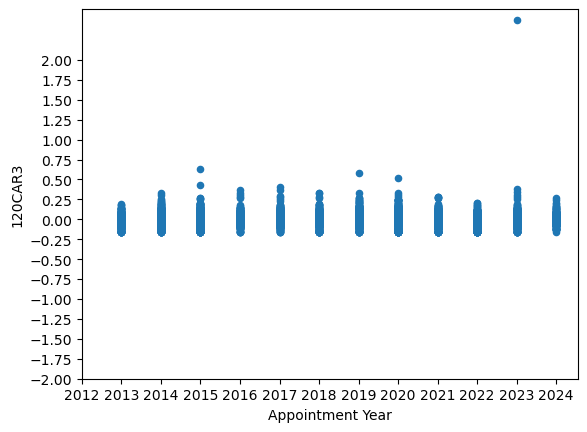

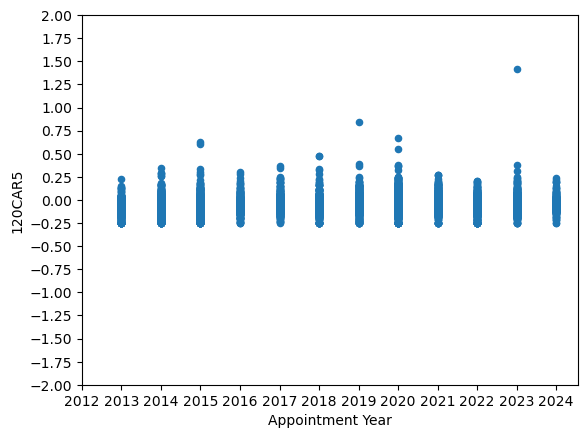

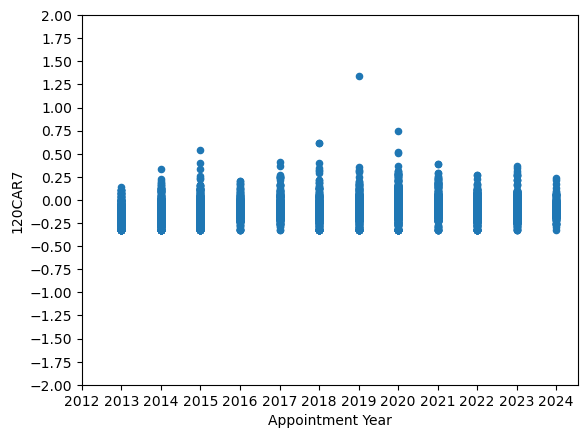

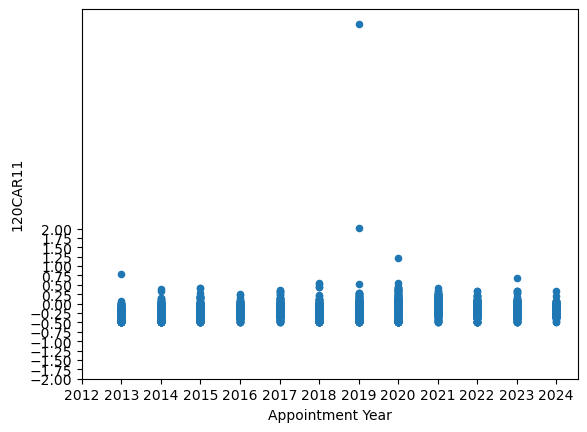

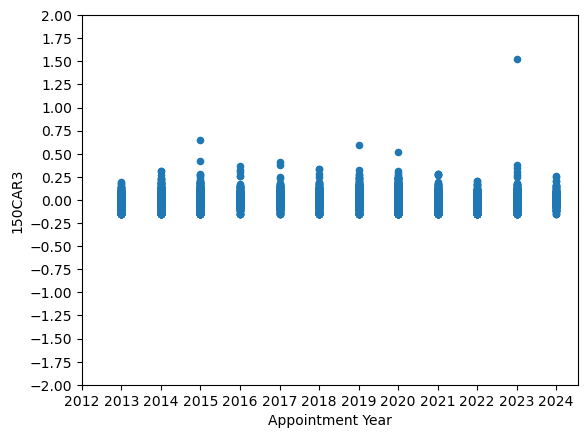

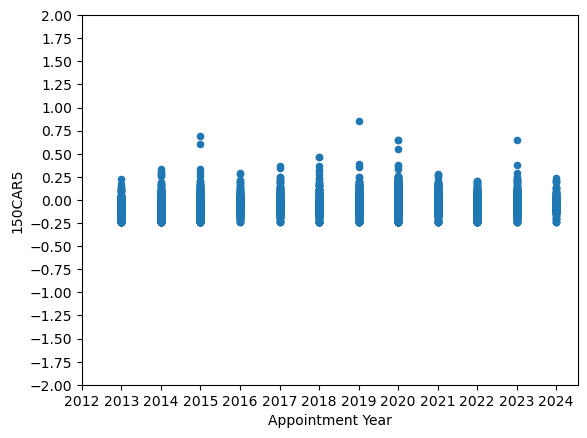

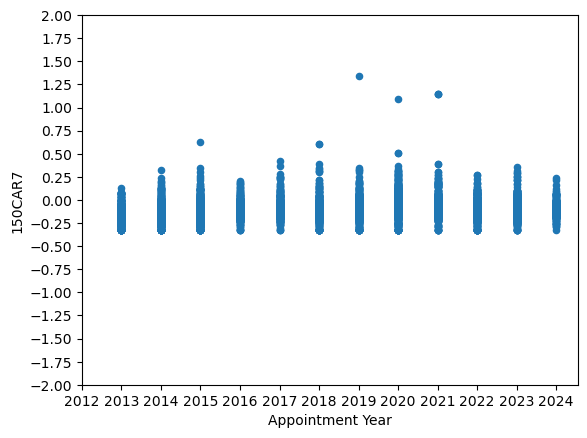

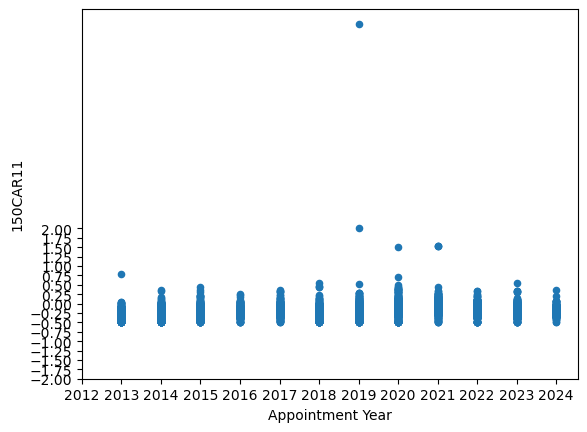

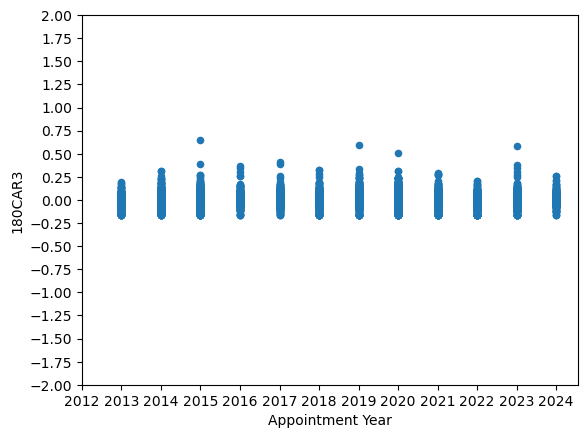

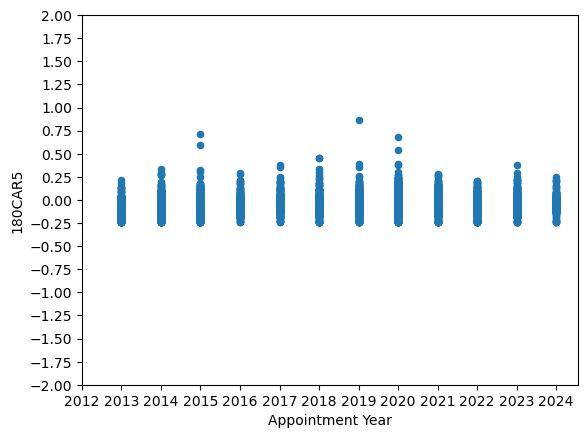

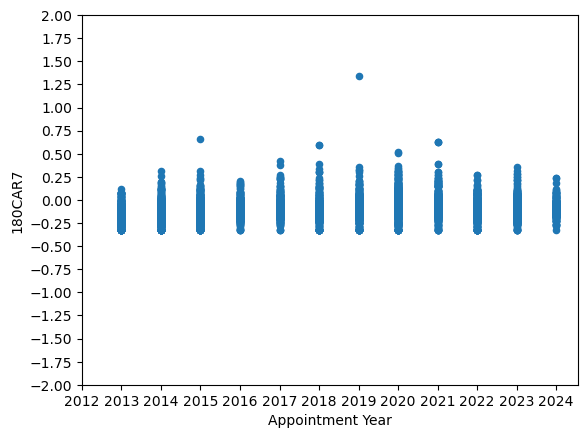

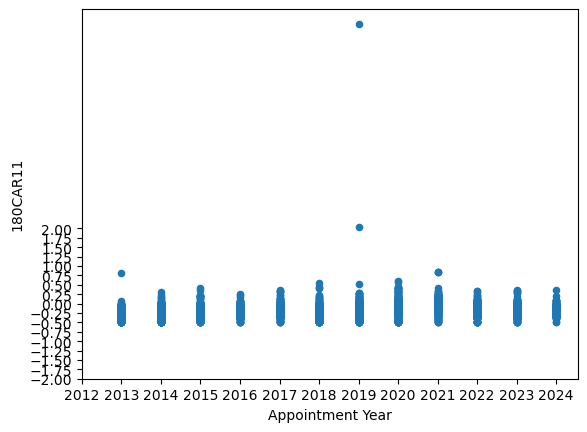

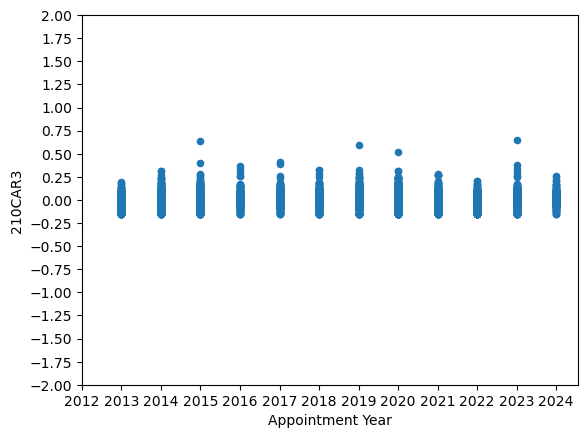

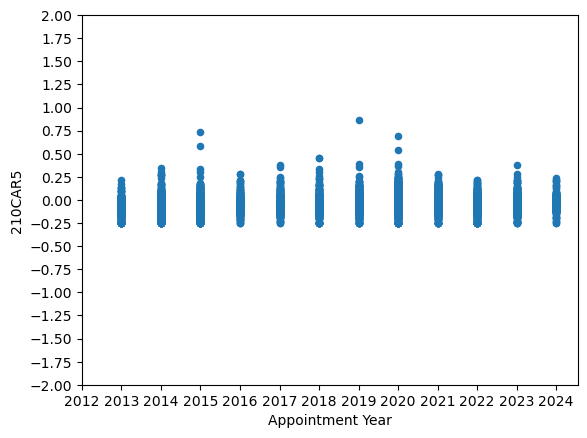

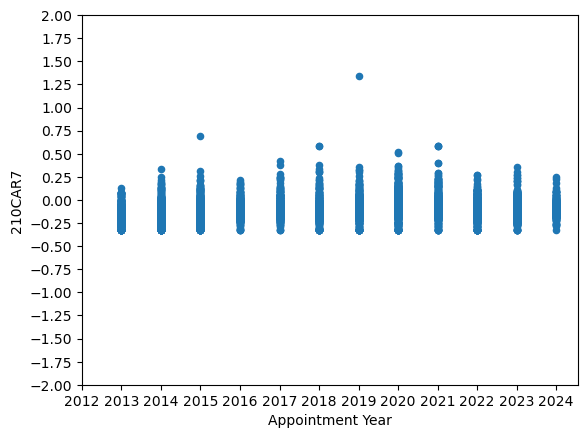

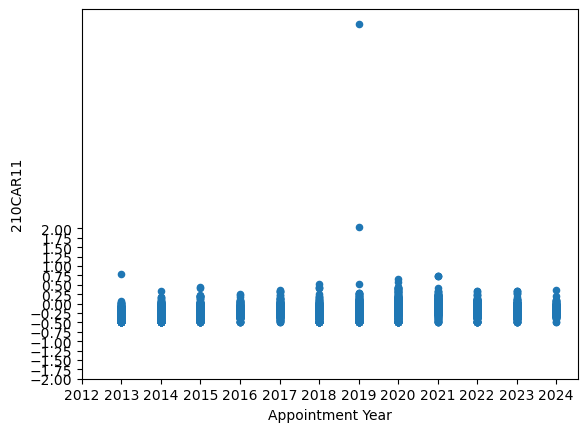

In [25]:
test = psmSampleIndep.copy()

carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

for car in carCol:
    test[car] = winsorize(test[car].values, limits = [0.01, 0.01]).data
    test[[car, "Appointment Year"]].plot(kind = "scatter", x="Appointment Year", y=car, xticks = np.arange(2012, 2025, step = 1), yticks = np.arange(-2, 2.25, step = 0.25))

In [26]:
test.describe()

,AsOnDate,AsOnYear,Date of Birth,Tenure Valid till,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,Prowess company code,IsMBA,IsPhD,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,HasTechSkill,HasFinanceSkill,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,committee_scientific,committee_strategic_planning,committee_manufacturing_supply_chain,combined_sustainability,combined_entrepreneurial,combined_compensation,combined_conglomerate_experience,combined_hr,combined_technology,combined_finance_accounting,combined_governance,combined_government_policy,combined_international,combined_leadership,combined_legal,combined_marketing,combined_risk_management,combined_scientific,combined_strategic_planning,combined_manufacturing_supply_chain,NumSkills_dummies,Total No.of Board Meetings Held,No.of Meetings Attended,percent_board_absence,ProwessCode,ACP,pct,RF,RMRF,MF,SMB,HML,OLS120_intercept,OLS120_RMRF,OLS120_SMB,OLS120_HML,OLS120_r_squared,OLS120_adjusted_r_squared,OLS120_f_p_value,120CAR3,120CAR5,120CAR7,120CAR11,OLS150_intercept,OLS150_RMRF,OLS150_SMB,OLS150_HML,OLS150_r_squared,OLS150_adjusted_r_squared,OLS150_f_p_value,150CAR3,150CAR5,150CAR7,150CAR11,OLS180_intercept,OLS180_RMRF,OLS180_SMB,OLS180_HML,OLS180_r_squared,OLS180_adjusted_r_squared,OLS180_f_p_value,180CAR3,180CAR5,

In [27]:
test.loc[ test["120CAR3"] >= 2]

,Symbol,Company,AsOnDate,AsOnYear,ISIN,Person Code,Director Salutation,Director First Name,Director Middle Name,Director Surname,Date of Birth,Gender,Nationality,Member of Civil Services,Promoter Director (Yes/No),Position on Board,Independent (Yes/No),Education1,Education2,Education3,Education4,Education5,Education6,Education7,Education8,Education9,Education10,Skills/Competencies,Occupation,Cessation Reason,Other Directorship 1,Other Directorship 2,Other Directorship 3,Other Directorship 4,Other Directorship 5,Other Directorship 6,Other Directorship 7,Other Directorship 8,Other Directorship 9,Other Directorship 10,Other Directorship 11,Other Directorship 12,Other Directorship 13,Other Directorship 14,Other Directorship 15,Brief Profile,Tenure Valid till,Indep,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,AllPastDirect,CurrDirectA,CurrDirectAB,PastSiezedDirectA,PastSiezedDirectAB,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,Rookie,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,NSE symbol,NIC code,Entity type,Ownership group,Prowess company code,CompanyName,Skills,EducationAll,IsMBA,IsPhD,AllPastDirectNIC,CurrDirectANIC,CurrDirectABNIC,AllNIC,AllNIC_Industry,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,SkillsInPositiononBoard,SkillsInOccupation,AllSkills,HasTechSkill,HasFinanceSkill,FirmsPast,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,Committee Name,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,co

In [34]:
test.loc[ test["120CAR11"] >= 1]

,Symbol,Company,AsOnDate,AsOnYear,ISIN,Person Code,Director Salutation,Director First Name,Director Middle Name,Director Surname,Date of Birth,Gender,Nationality,Member of Civil Services,Promoter Director (Yes/No),Position on Board,Independent (Yes/No),Education1,Education2,Education3,Education4,Education5,Education6,Education7,Education8,Education9,Education10,Skills/Competencies,Occupation,Cessation Reason,Other Directorship 1,Other Directorship 2,Other Directorship 3,Other Directorship 4,Other Directorship 5,Other Directorship 6,Other Directorship 7,Other Directorship 8,Other Directorship 9,Other Directorship 10,Other Directorship 11,Other Directorship 12,Other Directorship 13,Other Directorship 14,Other Directorship 15,Brief Profile,Tenure Valid till,Indep,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,AllPastDirect,CurrDirectA,CurrDirectAB,PastSiezedDirectA,PastSiezedDirectAB,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,Rookie,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,NSE symbol,NIC code,Entity type,Ownership group,Prowess company code,CompanyName,Skills,EducationAll,IsMBA,IsPhD,AllPastDirectNIC,CurrDirectANIC,CurrDirectABNIC,AllNIC,AllNIC_Industry,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,SkillsInPositiononBoard,SkillsInOccupation,AllSkills,HasTechSkill,HasFinanceSkill,FirmsPast,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,Committee Name,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,co

### RID

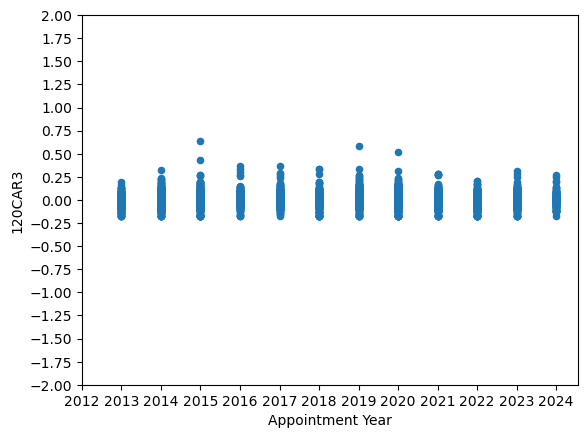

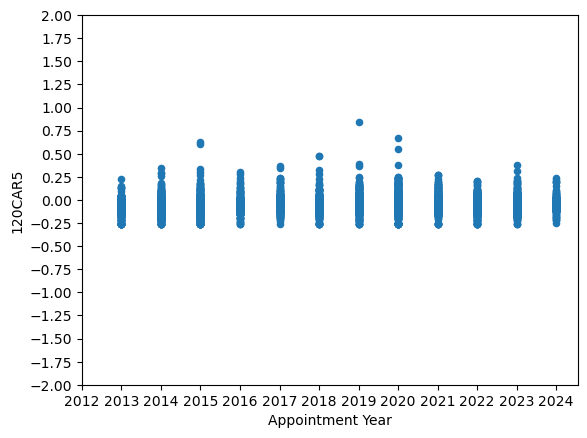

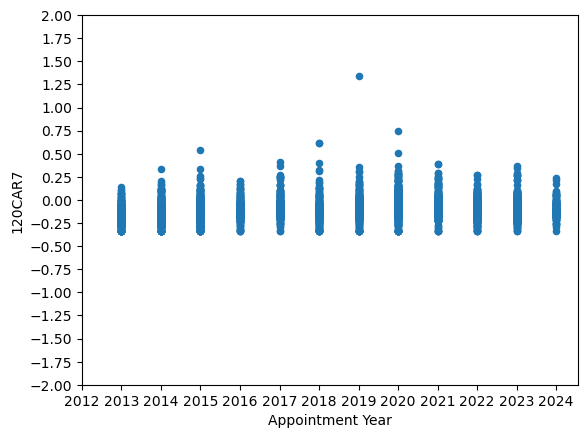

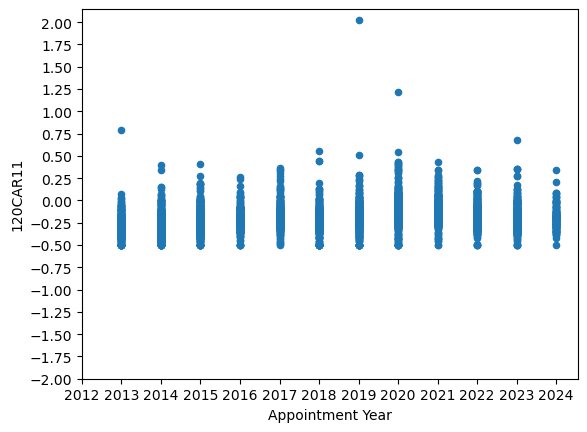

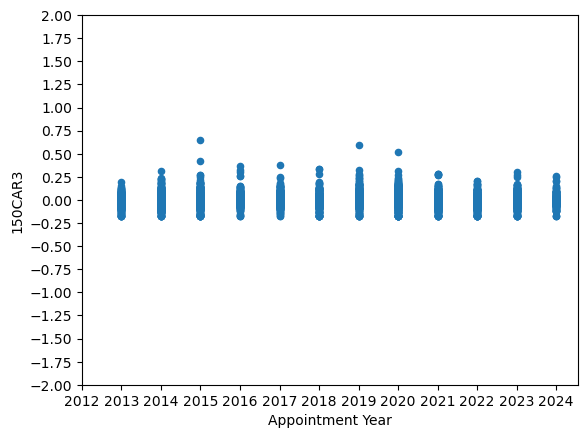

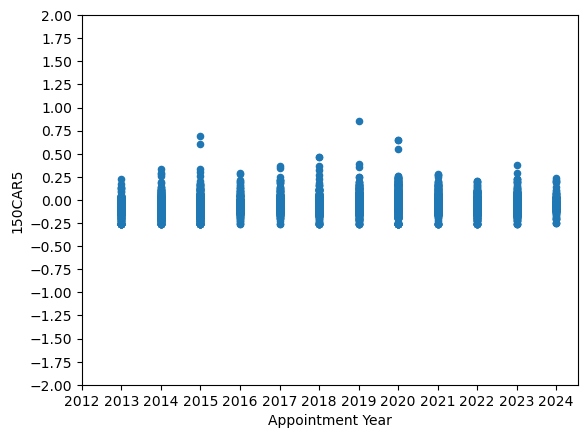

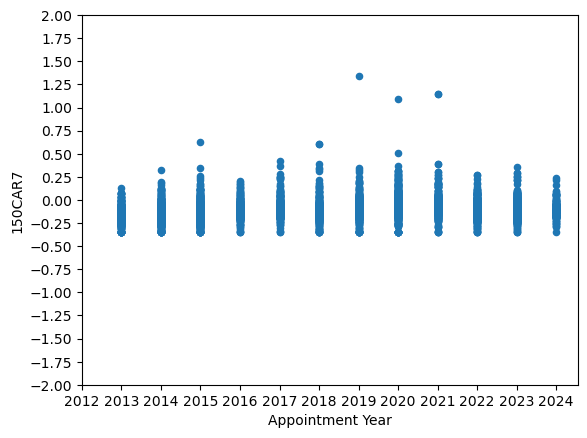

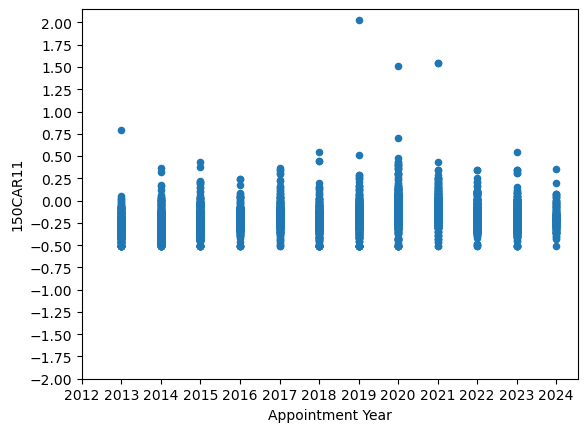

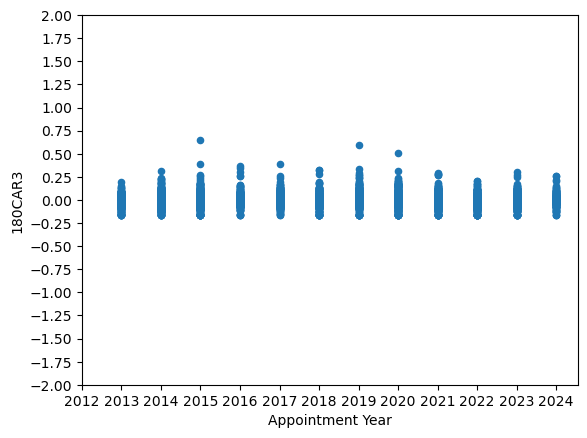

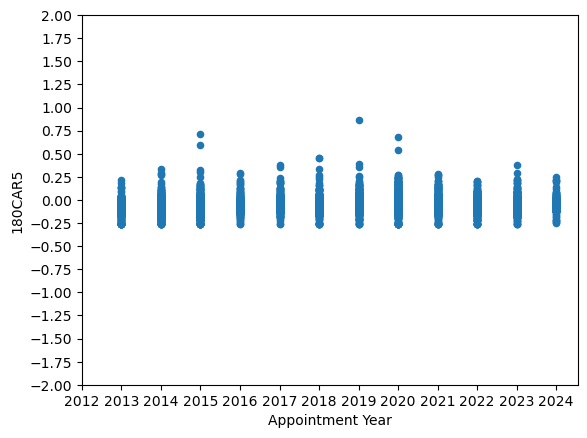

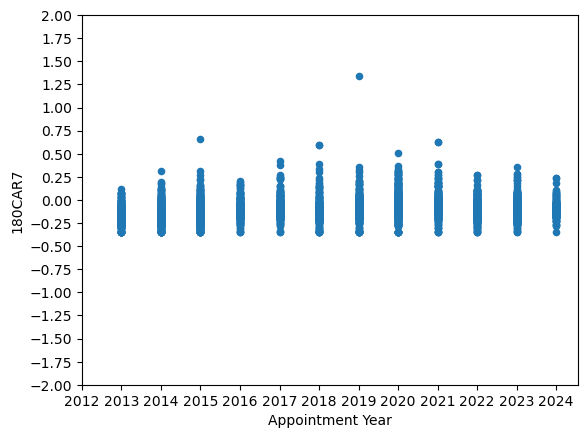

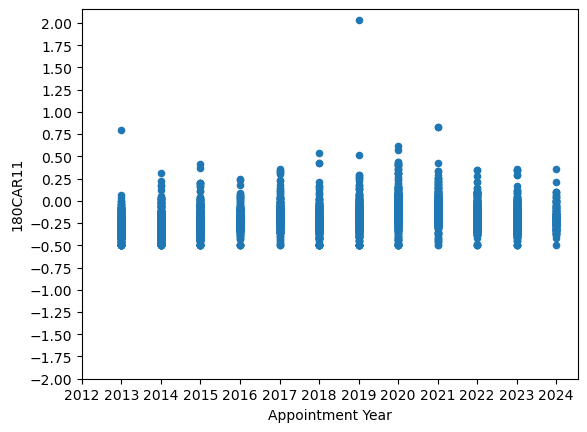

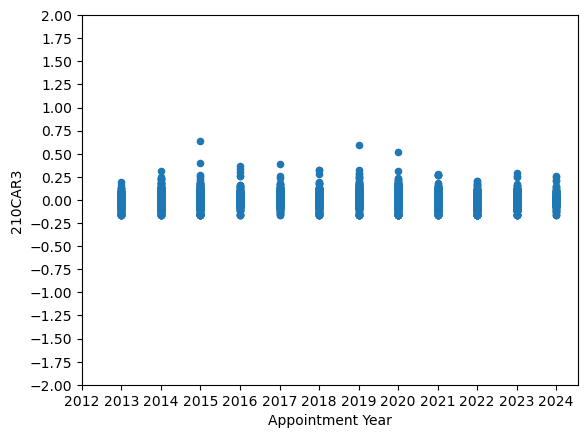

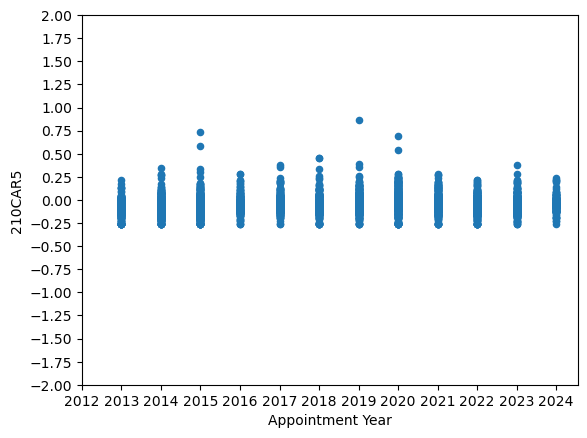

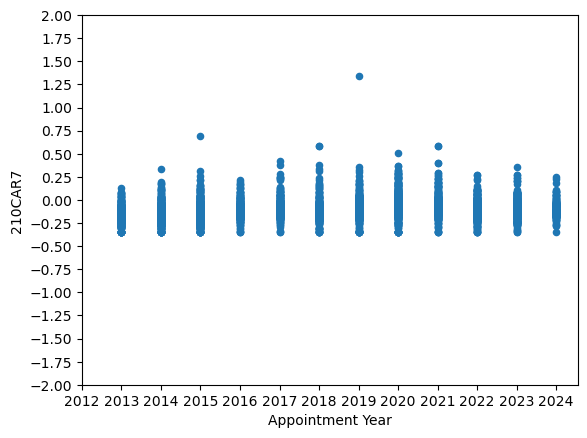

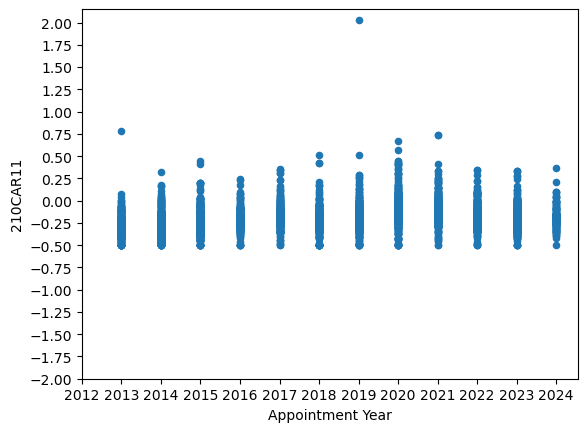

In [18]:
test = psmSampleIndep.loc[ psmSampleIndep["IsRookieIndep"] == 1 ].copy()

carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

for car in carCol:
    test[car] = winsorize(test[car].values, limits = [0.01, 0.01]).data
    test[[car, "Appointment Year"]].plot(kind = "scatter", x="Appointment Year", y=car, xticks = np.arange(2012, 2025, step = 1), yticks = np.arange(-2, 2.25, step = 0.25))

In [19]:
test.describe()

,AsOnDate,AsOnYear,Date of Birth,Tenure Valid till,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,Prowess company code,IsMBA,IsPhD,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,HasTechSkill,HasFinanceSkill,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,committee_scientific,committee_strategic_planning,committee_manufacturing_supply_chain,combined_sustainability,combined_entrepreneurial,combined_compensation,combined_conglomerate_experience,combined_hr,combined_technology,combined_finance_accounting,combined_governance,combined_government_policy,combined_international,combined_leadership,combined_legal,combined_marketing,combined_risk_management,combined_scientific,combined_strategic_planning,combined_manufacturing_supply_chain,NumSkills_dummies,Total No.of Board Meetings Held,No.of Meetings Attended,percent_board_absence,ProwessCode,ACP,pct,RF,RMRF,MF,SMB,HML,OLS120_intercept,OLS120_RMRF,OLS120_SMB,OLS120_HML,OLS120_r_squared,OLS120_adjusted_r_squared,OLS120_f_p_value,120CAR3,120CAR5,120CAR7,120CAR11,OLS150_intercept,OLS150_RMRF,OLS150_SMB,OLS150_HML,OLS150_r_squared,OLS150_adjusted_r_squared,OLS150_f_p_value,150CAR3,150CAR5,150CAR7,150CAR11,OLS180_intercept,OLS180_RMRF,OLS180_SMB,OLS180_HML,OLS180_r_squared,OLS180_adjusted_r_squared,OLS180_f_p_value,180CAR3,180CAR5,

### Non RID

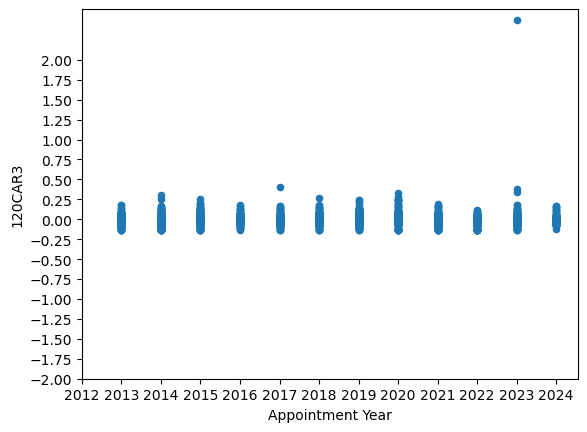

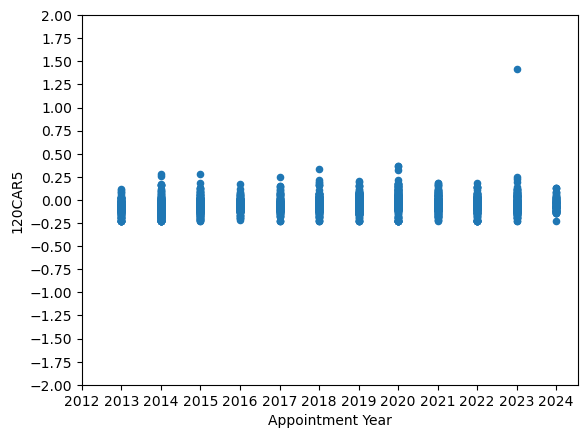

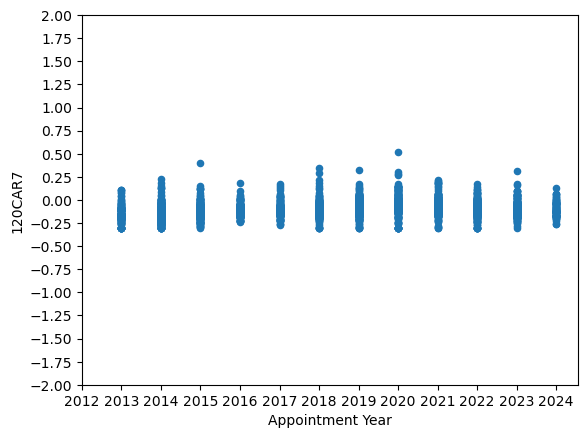

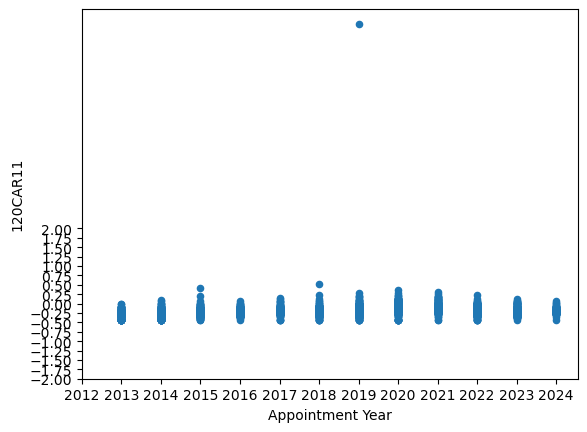

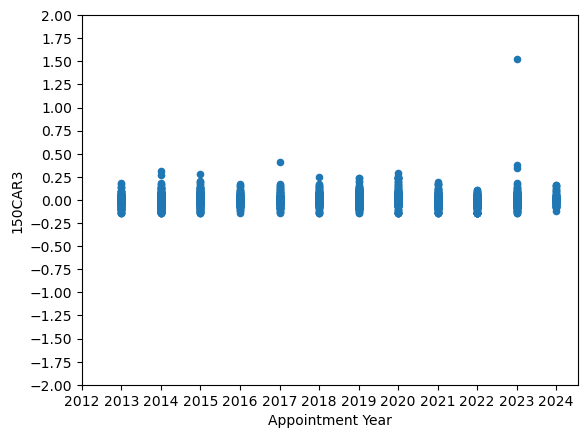

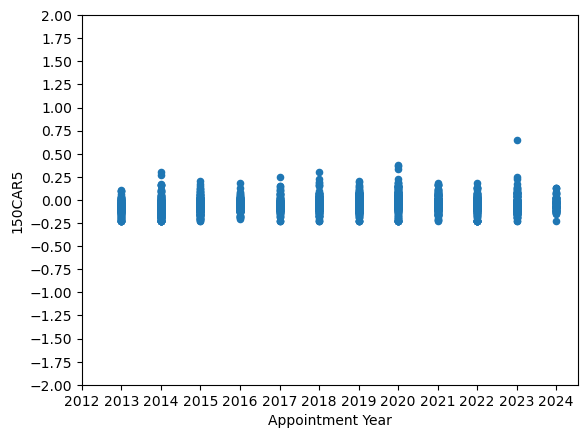

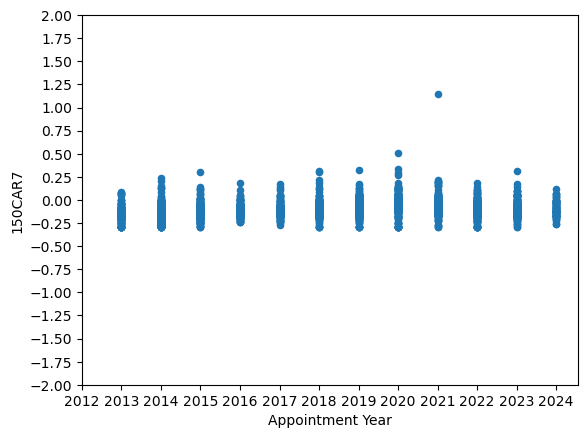

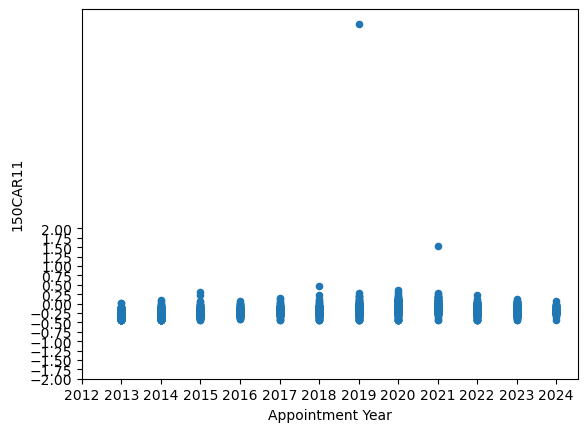

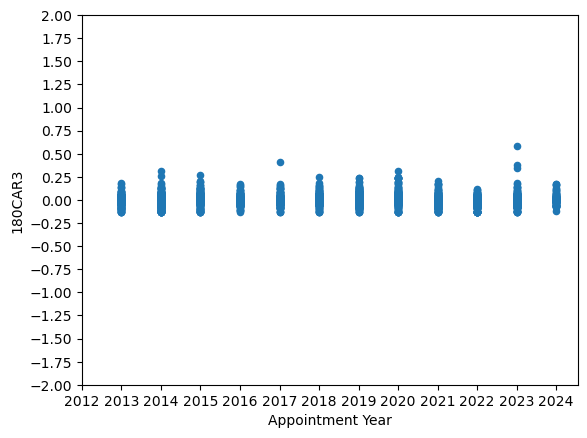

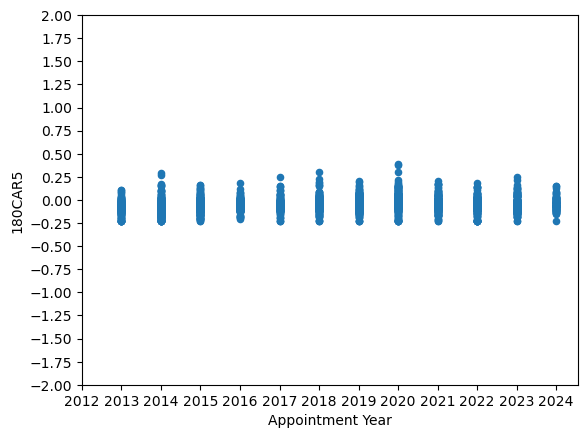

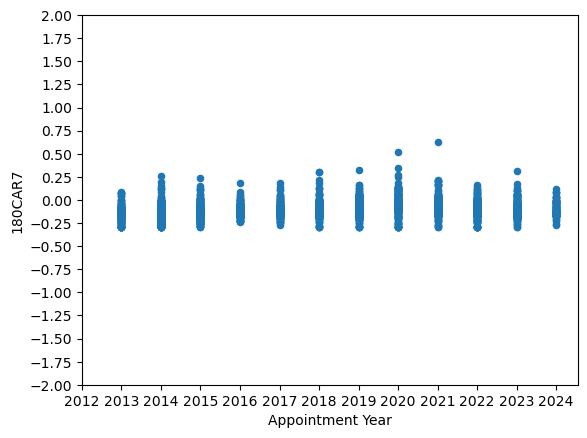

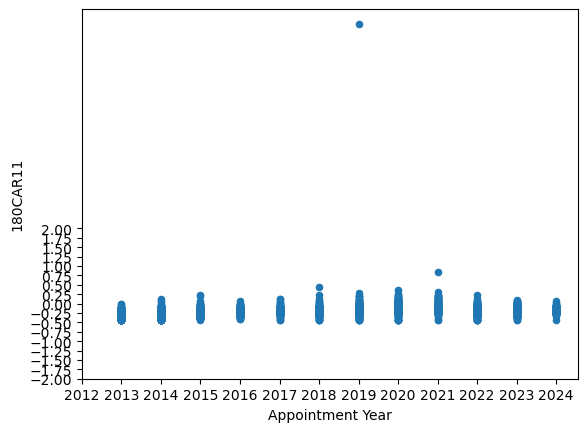

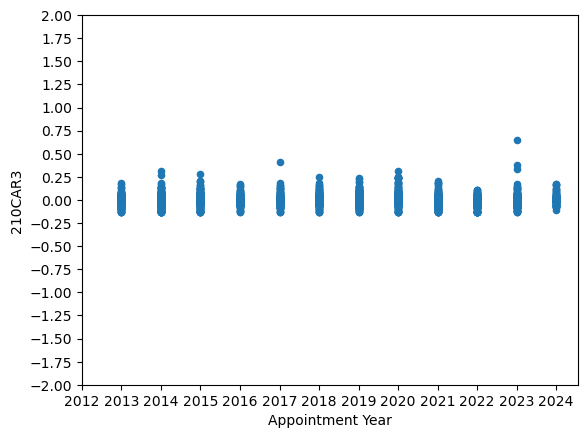

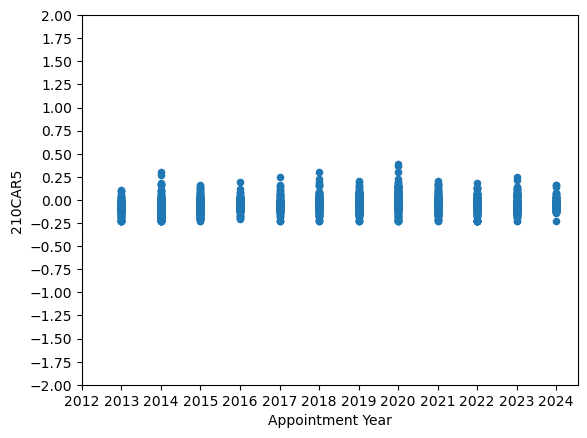

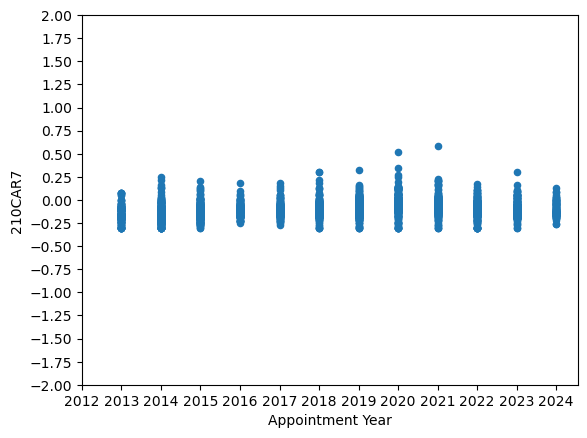

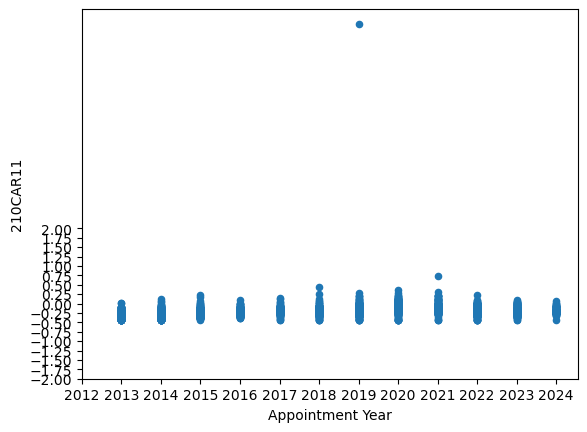

In [20]:
test = psmSampleIndep.loc[ psmSampleIndep["IsRookieIndep"] == 0 ].copy()

carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

for car in carCol:
    test[car] = winsorize(test[car].values, limits = [0.01, 0.01]).data
    test[[car, "Appointment Year"]].plot(kind = "scatter", x="Appointment Year", y=car, xticks = np.arange(2012, 2025, step = 1), yticks = np.arange(-2, 2.25, step = 0.25))

In [21]:
test.describe()

,AsOnDate,AsOnYear,Date of Birth,Tenure Valid till,Appointment Date,Cessation Date,PrevLastServed,NextServed,CessationDummy,ReappointDummy,TermStartDummy,TermNumber,AppointDummy,CumOpBalUnc,CumOpBalIndep,CumOpBalNonIndep,CumCloBalUnc,CumCloBalIndep,CumCloBalNonIndep,TermOpBalUnc,TermOpBalIndep,TermOpBalNonIndep,TermOpBalTotal,TermCloBalUnc,TermCloBalIndep,TermCloBalNonIndep,TermCloBalTotal,CompOpBalUnc,CompOpBalIndep,CompOpBalNonIndep,CompOpBalTotal,CompCloBalUnc,CompCloBalIndep,CompCloBalNonIndep,CompCloBalTotal,CloBalTotalXP,CountOtherPastUnclearA,CountOtherPastIndepA,CountOtherPastNonIndepA,CompCountOtherPastTotalA,CountOtherPastUnclearAB,CountOtherPastIndepAB,CountOtherPastNonIndepAB,CompCountOtherPastTotalAB,CountCurrUnclearA,CountCurrIndepA,CountCurrNonIndepA,CompCountCurrTotalA,CountCurrUnclearAB,CountCurrIndepAB,CountCurrNonIndepAB,CompCountCurrTotalAB,IsIndep,IsNonIndep,IsRookie,IsNonRookie,IsCeoMDPosition,IsChairmanPosition,IsCeoMDOccupation,IsChairmanOccupation,IsCeoMD,IsChairman,IsPromoterClassification,IsPromoterBoard,IsPromoter,IsDualityChairmanMD,IsFamilyManager,IsFamilyChairman,IsFamilyChairmanAndCEO,IsRookieIndep,IsRookieNonIndep,IsNonRookieIndep,IsNonRookieNonIndep,IsFemale,Age,TenureInYearsinCompIndep,TenureInYearsinCompTotal,IsFirstTerm,IsFirstTermIndep,IsOneYear,IsOneYearIndep,IsTwoYear,IsTwoYearIndep,IsThreeYear,IsThreeYearIndep,IsRetires5y,IsTermLimitRetirement,IsDefaultTerm,IsBusy,IsTurnOver,HasRetires5y,HasTermLimitRetirement,IsTurnOverIndep,Prowess company code,IsMBA,IsPhD,HasFinanceXP,HasTechXP,HasRelatedIndustryXP,IsExecCurrent,NumExecAll,IsOutsideExecXP,HasExecXP,PublicExecXPDummy,PrivateExecXPDummy,HasPublicExecXP,HasPrivateExecXP,HasTechSkill,HasFinanceSkill,NumSkills,NumFirmsPast,NumIndustryPast,HasCeoMDChairXP,HasConglomerateXP,skilllist_sustainability,skilllist_entrepreneurial,skilllist_compensation,skilllist_conglomerate_experience,skilllist_hr,skilllist_technology,skilllist_finance_accounting,skilllist_governance,skilllist_government_policy,skilllist_international,skilllist_leadership,skilllist_legal,skilllist_marketing,skilllist_risk_management,skilllist_scientific,skilllist_strategic_planning,skilllist_manufacturing_supply_chain,Academic,Manufacturing,Outside Board,Company Business,profile_sustainability,profile_entrepreneurial,profile_compensation,profile_conglomerate_experience,profile_hr,profile_technology,profile_finance_accounting,profile_governance,profile_government_policy,profile_international,profile_leadership,profile_legal,profile_marketing,profile_risk_management,profile_scientific,profile_strategic_planning,profile_manufacturing_supply_chain,committee_sustainability,committee_entrepreneurial,committee_compensation,committee_conglomerate_experience,committee_hr,committee_technology,committee_finance_accounting,committee_governance,committee_government_policy,committee_international,committee_leadership,committee_legal,committee_marketing,committee_risk_management,committee_scientific,committee_strategic_planning,committee_manufacturing_supply_chain,combined_sustainability,combined_entrepreneurial,combined_compensation,combined_conglomerate_experience,combined_hr,combined_technology,combined_finance_accounting,combined_governance,combined_government_policy,combined_international,combined_leadership,combined_legal,combined_marketing,combined_risk_management,combined_scientific,combined_strategic_planning,combined_manufacturing_supply_chain,NumSkills_dummies,Total No.of Board Meetings Held,No.of Meetings Attended,percent_board_absence,ProwessCode,ACP,pct,RF,RMRF,MF,SMB,HML,OLS120_intercept,OLS120_RMRF,OLS120_SMB,OLS120_HML,OLS120_r_squared,OLS120_adjusted_r_squared,OLS120_f_p_value,120CAR3,120CAR5,120CAR7,120CAR11,OLS150_intercept,OLS150_RMRF,OLS150_SMB,OLS150_HML,OLS150_r_squared,OLS150_adjusted_r_squared,OLS150_f_p_value,150CAR3,150CAR5,150CAR7,150CAR11,OLS180_intercept,OLS180_RMRF,OLS180_SMB,OLS180_HML,OLS180_r_squared,OLS180_adjusted_r_squared,OLS180_f_p_value,180CAR3,180CAR5,

In [22]:
aa

NameError: name 'aa' is not defined

## Panel A: Whole Sample

### Mean Difference

In [ ]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

for car in carCol:
    sample = psmSampleIndep.dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

In [ ]:
### PSM without replacement
# PsmNonReplac(psmSampleIndep, "RookieIndepAppointDummy", controlVars, "ln_TobinQ_longborrowincl2", dirFirm)

### One Sample T Test

In [ ]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

for car in carCol:
    sample1 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 1].copy()
    print("Rookie Independent Directors:")
    sample = sample1.dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    sample2 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 0].copy()
    print("Non Rookie Independent Directors:")
    sample = sample2.dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)


## Panel B: Unique skills dummy

### Mean Difference

In [ ]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

for car in carCol:
    print("No unique skills:")
    sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] == 0].dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("At least one unique skill:")
    sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] != 0].dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

### One Sample T Test

In [ ]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

for car in carCol:
    sample1 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 1].copy()
    print("Rookie Independent Directors\nNo unique skills:")
    sample = sample1.loc[sample1["NumSkills_dummies"] == 0].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("At least one unique skill:")
    sample = sample1.loc[sample1["NumSkills_dummies"] != 0].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    sample2 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 0].copy()
    print("Non Rookie Independent Directors\nNo unique skills:")
    sample = sample2.loc[sample2["NumSkills_dummies"] == 0].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("At least one unique skill:")
    sample = sample2.loc[sample2["NumSkills_dummies"] != 0].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

In [ ]:
### PSM without replacement
# PsmNonReplac(psmSampleIndep, "RookieIndepAppointDummy", controlVars, "ln_TobinQ_longborrowincl2", dirFirm)

## Panel C: Number of Skills

### Mean Difference

In [ ]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

num_skills_median = psmSampleIndep.drop_duplicates(subset = ["AsOnDate", "Person Code"])["NumSkills_dummies"].median()
for car in carCol:
    print("Less than median no. skills:")
    sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] < num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("Greater than median no. skills:")
    sample = psmSampleIndep.loc[psmSampleIndep["NumSkills_dummies"] > num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    MeanDiffTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

### One Sample T Test

In [ ]:
carCol = ["120CAR3", "120CAR5", "120CAR7", "120CAR11", 
          "150CAR3", "150CAR5", "150CAR7", "150CAR11", 
          "180CAR3", "180CAR5", "180CAR7", "180CAR11",
          "210CAR3", "210CAR5", "210CAR7", "210CAR11"]

exog_var = None
depVar = None
controlVars = None

num_skills_median = psmSampleIndep.drop_duplicates(subset = ["AsOnDate", "Person Code"])["NumSkills_dummies"].median()
for car in carCol:
    sample1 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 1].copy()
    print("Rookie Independent Directors\nLess than median no. skills:")
    sample = sample1.loc[sample1["NumSkills_dummies"] < num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("Greater than median no. skills:")
    sample = sample1.loc[sample1["NumSkills_dummies"] < num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    sample2 = psmSampleIndep.loc[psmSampleIndep["IsRookieIndep"] == 0].copy()
    print("Non Rookie Independent Directors\nLess than median no. skills:")
    sample = sample2.loc[sample2["NumSkills_dummies"] > num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

    print("Greater than median no. skills:")
    sample = sample2.loc[sample2["NumSkills_dummies"] > num_skills_median].dropna(subset = car).reset_index(drop=True).copy()
    OneSampleTtest(sample, "IsRookieIndep", exog_var, car, depVar, dirFirm)

In [ ]:
### PSM without replacement
# PsmNonReplac(psmSampleIndep, "RookieIndepAppointDummy", controlVars, "ln_TobinQ_longborrowincl2", dirFirm)